# 1. 수요지점 히트맵 시각화

In [ ]:
!pip install pydeck geopandas pandas
!pip install folium
!pip install branca
!pip install geopandas

In [2]:
from shapely.geometry import Point
import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
import branca.colormap as cm

In [11]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# 데이터 로드
li = pd.read_csv('/content/drive/MyDrive/MCLP_data/li.csv')
sights = pd.read_csv('/content/drive/MyDrive/MCLP_data/sight_0720.csv')
hotels = pd.read_csv('/content/drive/MyDrive/MCLP_data/hotel_0720.csv')
rests = pd.read_csv('/content/drive/MyDrive/MCLP_data/rests_0720.csv')
cafes = pd.read_csv('/content/drive/MyDrive/MCLP_data/cafe_0720.csv')
store = pd.read_csv('/content/drive/MyDrive/MCLP_data/store_0720.csv')
oil = pd.read_csv('/content/drive/MyDrive/MCLP_data/oil_0720.csv')
golf = pd.read_csv('/content/drive/MyDrive/MCLP_data/golf_0720.csv')
pension = pd.read_csv('/content/drive/MyDrive/MCLP_data/pension_0720.csv')
houses = pd.read_csv('/content/drive/MyDrive/MCLP_data/houses_0720.csv')
uses_houses = pd.read_csv('/content/drive/MyDrive/MCLP_data/uses_houses.csv')
sights_m = pd.read_csv('/content/drive/MyDrive/MCLP_data/sight_0720.csv')

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


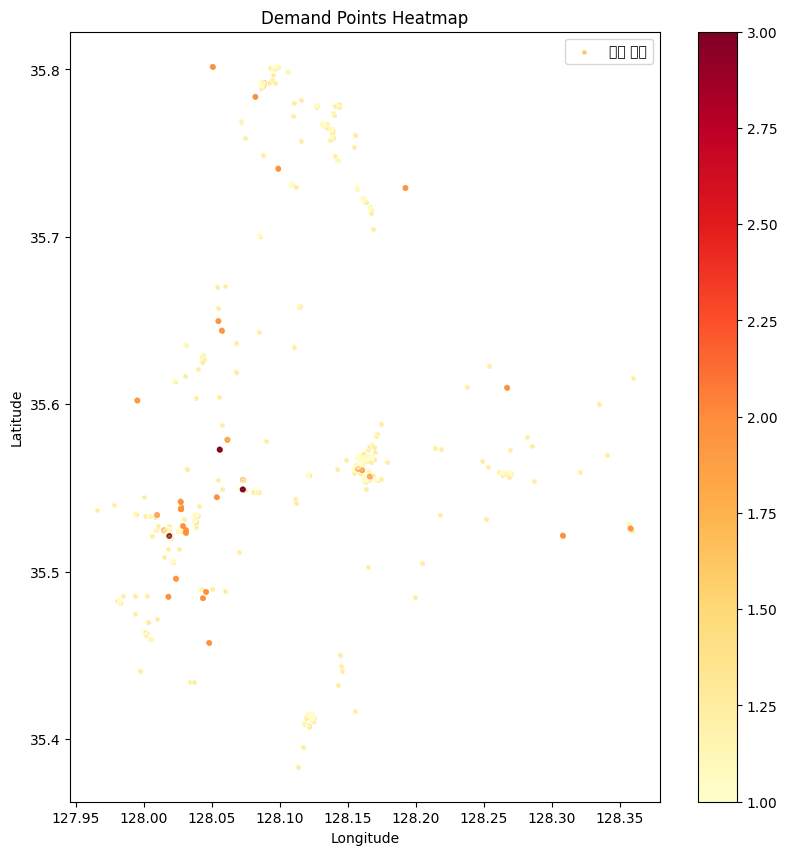

In [13]:
# 지리정보 데이터프레임 생성
li = li[['region', 'lat', 'lng']]
li = gpd.GeoDataFrame(li, geometry=gpd.points_from_xy(li.lng, li.lat))
li.crs = 'epsg:4326'

# 수요 지점 데이터를 하나의 GeoDataFrame으로 결합
csvs = [sights, rests, cafes, store, oil, golf, pension, hotels]

for i, place in enumerate(csvs):
    csvs[i] = place[['이름', 'lat', 'lng']]
    csvs[i] = gpd.GeoDataFrame(csvs[i], geometry=gpd.points_from_xy(csvs[i]['lng'], csvs[i]['lat']))
    csvs[i].crs = 'epsg:4326'

points = pd.concat(csvs, ignore_index=True)
points['weights'] = 1  # 가중치 설정 (필요시 수정)

# 히트맵 시각화
fig, ax = plt.subplots(figsize=(10, 10))
points.plot(ax=ax, marker='o', color='orange', markersize=5, alpha=0.5, label='수요 지점')

# 수요량에 따라 색상을 다르게 표시
points['counts'] = points.groupby(['geometry'])['geometry'].transform('count')
points.plot(column='counts', ax=ax, legend=True, cmap='YlOrRd', markersize=10, alpha=0.6)

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Demand Points Heatmap')
plt.show()

# 2. 수요지점 지도 시각화

In [14]:
# 여러 데이터프레임을 하나로 결합
csvs = [sights, rests, cafes, store, oil, golf, pension, hotels]

for i, place in enumerate(csvs):
    csvs[i] = place[['lat', 'lng']]
    csvs[i]['weight'] = 1  # 수요량을 나타내는 가중치 컬럼 추가 (필요에 따라 수정)

points = pd.concat(csvs, ignore_index=True)

# GeoDataFrame으로 변환
geometry = [Point(xy) for xy in zip(points['lng'], points['lat'])]
gdf_points = gpd.GeoDataFrame(points, geometry=geometry)

# folium을 사용하여 지도 생성
center = [35.5663, 128.1655]  # 합천군의 중심 좌표
m = folium.Map(location=center, zoom_start=13)

# 히트맵 추가
heat_data = [[row.geometry.y, row.geometry.x, row['weight']] for index, row in gdf_points.iterrows()]
HeatMap(heat_data, radius=15).add_to(m)

# 색상표 추가
colormap = cm.LinearColormap(colors=['blue', 'green', 'yellow', 'orange', 'red'],
                             vmin=0, vmax=1)
colormap.caption = 'Demand Intensity'
colormap.add_to(m)

# 지도 저장 및 표시
m.save('/content/hapcheon_heatmap_with_legend.html')

# Display the map in Jupyter/Colab
m